# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
import pickle
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


1. May need to split out channels into separate columns for each.
2. Other columns seem organized.

In [4]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

In [5]:
portfolio_clean = clean_portfolio(portfolio)

In [6]:
portfolio_clean

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    
    return profile

In [10]:
cleaned_profile = clean_profile(profile)

In [11]:
cleaned_profile.head()

,age,became_member_on,gender,id,income,memberdays
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1362
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1429
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1077
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1153
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1243


In [12]:
cleaned_profile.describe()

,age,became_member_on,income,memberdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,1508.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,986.000000
25%,42.000000,2.016052e+07,49000.000000,1194.000000
50%,55.000000,2.017080e+07,64000.000000,1344.000000
75%,66.000000,2.017123e+07,80000.000000,1783.000000
max,101.000000,2.018073e+07,120000.000000,2809.000000


In [13]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    user_age = cleaned_profile['age'].plot(kind='hist',color='magenta', bins=20, title='Distribution of Customer Age')
    user_age.set_xlabel("Customer Age")
       
    # Display Histogram of the days being member
    plt.figure()
    memberdays = cleaned_profile['memberdays'].plot(kind='hist',color='magenta', bins=50, title='How long did the users become our members?')
    memberdays.set_xlabel("Days")
    
    # Display Histogram of User Income
    plt.figure()
    user_income = cleaned_profile['income'].plot(kind='hist',color='magenta', bins=20, title='Distribution of Customer Income')
    user_income.set_xlabel("Income")

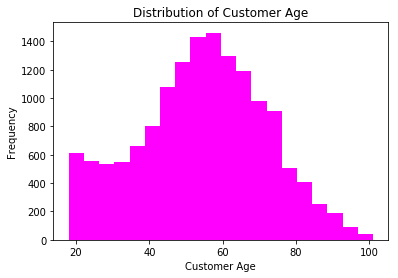

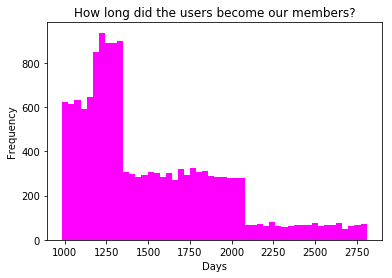

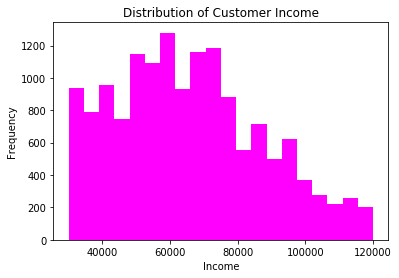

In [14]:
display_customer_profile()

In [15]:
# explore transcript
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [16]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
# select one user and explore the transcript records
transcript[transcript['person']=='8ec6ce2a7e7949b1bf142def7d0e0586']

,event,person,time,value
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
18067,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,12,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
53177,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,168,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
85292,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,216,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
120424,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
137418,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,366,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
160235,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,408,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
189198,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,462,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
201575,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
225063,offer viewed,8ec6ce2a7e7949b1bf142def7d0e0586,522,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [18]:
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [19]:
offer = clean_transcript(transcript)
offer

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [20]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [21]:
offer.shape

(167581, 5)

In [22]:
offer[offer['person']=='b895c57e8cd047a8872ce02aa54759d6']

,event,person,time,value,offer_id
12466,offer received,b895c57e8cd047a8872ce02aa54759d6,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
18030,offer viewed,b895c57e8cd047a8872ce02aa54759d6,6,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
45411,offer completed,b895c57e8cd047a8872ce02aa54759d6,114,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4
123351,offer received,b895c57e8cd047a8872ce02aa54759d6,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
141528,offer viewed,b895c57e8cd047a8872ce02aa54759d6,372,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
163193,offer received,b895c57e8cd047a8872ce02aa54759d6,408,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
195023,offer viewed,b895c57e8cd047a8872ce02aa54759d6,474,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
214104,offer received,b895c57e8cd047a8872ce02aa54759d6,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
225025,offer viewed,b895c57e8cd047a8872ce02aa54759d6,516,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
306506,offer completed,b895c57e8cd047a8872ce02aa54759d6,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4


In [23]:
user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
user_item_matrix.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:

def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [24]:
full_df = create_user_item_matrix(offer, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [25]:
# After getting a full dataframe we nee dto have training df and test df
#More training data the better? As long as we verify its not overfitting
train_size = int(offer.shape[0]*0.6)
test_size=offer.shape[0] - train_size
train_size,test_size

(100548, 67033)

In [33]:
train_offer = offer[:train_size]
test_offer = offer[train_size:]

In [28]:
train_df = create_user_item_matrix(train_offer,'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [29]:
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN


In [34]:
test_df = create_user_item_matrix(test_offer, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [35]:
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [27]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [25]:
# Run this cell if you want to omit the long process of matrix creation
full_df = pd.read_pickle('user_item_matrix.p')

train_df = pd.read_pickle('train_df.p')

test_df = pd.read_pickle('train_df.p')

In [28]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.293922
2 		 0.240965
3 		 0.240719
4 		 0.240463
5 		 0.240204
6 		 0.239941
7 		 0.239674
8 		 0.239403
9 		 0.239127
10 		 0.238845
11 		 0.238559
12 		 0.238266
13 		 0.237968
14 		 0.237663
15 		 0.237350
16 		 0.237031
17 		 0.236703
18 		 0.236367
19 		 0.236021
20 		 0.235666
21 		 0.235300
22 		 0.234923
23 		 0.234534
24 		 0.234132
25 		 0.233716
26 		 0.233287
27 		 0.232841
28 		 0.232379
29 		 0.231899
30 		 0.231401
31 		 0.230883
32 		 0.230343
33 		 0.229781
34 		 0.229195
35 		 0.228584
36 		 0.227945
37 		 0.227278
38 		 0.226581
39 		 0.225852
40 		 0.225089
41 		 0.224290
42 		 0.223454
43 		 0.222578
44 		 0.221661
45 		 0.220700
46 		 0.219694
47 		 0.218640
48 		 0.217536
49 		 0.216380
50 		 0.215171
51 		 0.213906
52 		 0.212583
53 		 0.211201
54 		 0.209757
55 		 0.208251
56 		 0.206680
57 		 0.205045
58 		 0.203343
59 		 0.201574
60 		 0.199738
61 		 0.197834
62 		 0.195863
63 		 0.193825
64 		 0

In [29]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.282043
2 		 0.240363
3 		 0.240034
4 		 0.239705
5 		 0.239373
6 		 0.239039
7 		 0.238702
8 		 0.238362
9 		 0.238018
10 		 0.237672
11 		 0.237321
12 		 0.236967
13 		 0.236608
14 		 0.236245
15 		 0.235877
16 		 0.235504
17 		 0.235126
18 		 0.234742
19 		 0.234352
20 		 0.233955
21 		 0.233551
22 		 0.233140
23 		 0.232721
24 		 0.232293
25 		 0.231857
26 		 0.231411
27 		 0.230955
28 		 0.230488
29 		 0.230009
30 		 0.229519
31 		 0.229015
32 		 0.228498
33 		 0.227966
34 		 0.227418
35 		 0.226854
36 		 0.226273
37 		 0.225673
38 		 0.225054
39 		 0.224414
40 		 0.223752
41 		 0.223067
42 		 0.222358
43 		 0.221623
44 		 0.220862
45 		 0.220072
46 		 0.219252
47 		 0.218401
48 		 0.217518
49 		 0.216600
50 		 0.215646
51 		 0.214656
52 		 0.213626
53 		 0.212555
54 		 0.211443
55 		 0.210287
56 		 0.209086
57 		 0.207839
58 		 0.206543
59 		 0.205198
60 		 0.203803
61 		 0.202357
62 		 0.200857
63 		 0.199304
64 		 0

In [30]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.254073
2 		 0.241312
3 		 0.240750
4 		 0.240185
5 		 0.239619
6 		 0.239051
7 		 0.238482
8 		 0.237911
9 		 0.237339
10 		 0.236765
11 		 0.236189
12 		 0.235612
13 		 0.235032
14 		 0.234451
15 		 0.233867
16 		 0.233282
17 		 0.232694
18 		 0.232103
19 		 0.231510
20 		 0.230915
21 		 0.230316
22 		 0.229715
23 		 0.229110
24 		 0.228502
25 		 0.227890
26 		 0.227275
27 		 0.226656
28 		 0.226032
29 		 0.225404
30 		 0.224772
31 		 0.224134
32 		 0.223491
33 		 0.222843
34 		 0.222188
35 		 0.221528
36 		 0.220861
37 		 0.220187
38 		 0.219505
39 		 0.218816
40 		 0.218119
41 		 0.217413
42 		 0.216698
43 		 0.215974
44 		 0.215240
45 		 0.214495
46 		 0.213739
47 		 0.212972
48 		 0.212192
49 		 0.211400
50 		 0.210594
51 		 0.209775
52 		 0.208940
53 		 0.208091
54 		 0.207226
55 		 0.206345
56 		 0.205446
57 		 0.204529
58 		 0.203595
59 		 0.202641
60 		 0.201667
61 		 0.200673
62 		 0.199658
63 		 0.198621
64 		 0

In [31]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None

In [32]:

def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [33]:
# Evaluation for latent features of 15
validation(test_df, user_mat, offer_mat)

0.00870015647527


In [34]:
# Evaluation for latent features of 10
validation(test_df, user_mat_10, offer_mat_10)

0.0142067572343


In [35]:
# Evaluation for latent features of 5
validation(test_df, user_mat_5, offer_mat_5)

0.0240576576021


In [36]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [37]:
# recommend offer for a particular user
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  1.16
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.28
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.24
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.24
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.21
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.03
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.01
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  -0.18


In [39]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


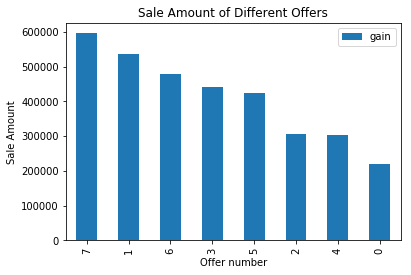

In [40]:
# we recommend top best sale offer to a new user
recommend_offer('new_user', user_mat, offer_mat)

In [41]:
def gender_offer(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

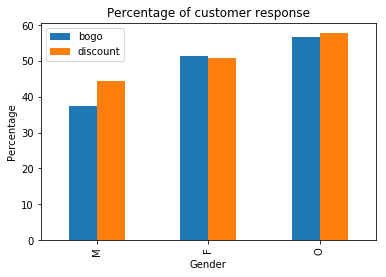

In [42]:
gender_offer(full_df)

In [45]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in portfolio_clean[(portfolio_clean[channel_type]==1)&(portfolio_clean['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

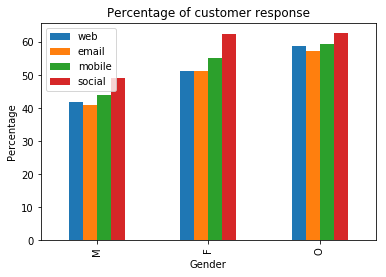

In [46]:
gender_offer_channel(full_df)

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


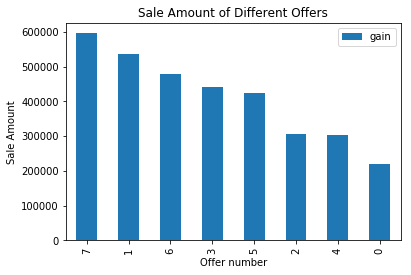

In [47]:
best_sale_offer(full_df)